<a href="https://colab.research.google.com/github/crystal-zhu/Sitcom_Success_Factors-CSDS_312/blob/main/B99_Analysis/B99_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import nltk
import requests
import pandas as pd

from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the Porter Stemmer and WordNet Lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Gensim stopwords
gensim_stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
url = "https://raw.githubusercontent.com/crystal-zhu/Sitcom_Success_Factors-CSDS_312/main/B99_Analysis/data/B99_Script/Brooklyn99_Season1-4_Dataset.csv"
response = requests.get(url)


# Check if the request was successful (status code 200)
if response.status_code == 200:
    with open("Brooklyn99_Season1-4_Dataset", "w") as f:
        f.write(response.text)
    print("CSV file downloaded successfully")
else:
    print("Failed to download CSV file. Status code:", response.status_code)

dialogue = pd.read_csv("Brooklyn99_Season1-4_Dataset")


CSV file downloaded successfully


LDA

# Preprocessing data



In order to run our LDA model, we must preprocess our data. We process our data using these steps.
*   Removing all non-word and non-whitespace characters
*   Keeping only the nouns in the lines using spacy. We keep only the nouns since it gave us the highest cohesiveness score and nouns were most likely to relate to each other in a line than other words.
* Cleaning all stop-words (commonly used words that don't have a true impact on the meaning of the line)
* Lemmatizing words so that words of different tenses will be treated as equal.





In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
nlp

In [ ]:


# Remove punctuations, stopwords, convert to lowercase, tokenize, stem, and lemmatize
def preprocess_text(text):
    # Use spaCy for POS tagging
    processed = nlp(text)
    cleaned_text = re.sub(r'[^\w\s]', '', text) # remove all non-word and non-whitespace characters from the text

    # Keep only nouns
    nouns = [token.text for token in processed if token.pos_ == "NOUN"]

    stop_words = set(gensim_stop_words)
    words = word_tokenize(cleaned_text.lower())
    filtered_words = [word for word in words if word not in stop_words and len(word) >= 4] # remove words have less than 4 characters

    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    return nouns

# Apply preprocessing to the 'line' column
dialogue['processed_text'] = dialogue['line'].apply(preprocess_text)
dialogue[1:300]


,name,line,processed_text
1,AMY,"Hey! What are you doing, weirdo?",[weirdo]
2,JAKE,I'm doing the best speech from Donnie Brasco....,"[speech, speech, screens, Sup]"
3,AMY,"Get it together, man. Okay?",[man]
4,AMY,So the store was hit about two hours ago. The...,"[store, hours, tablets, laptops, cameras]"
5,JAKE,Sorry.,[]
...,...,...,...
295,CHARLES,Lady bin?,[]
296,GINA,"Laundry basket. Oh, little boo-boo. Can you g...","[basket, boo, boo, area]"
297,TERRY,"Baby, I've got some bad news. Someone painted...","[news, penis, minivan, SUV, things, baby]"
298,JAKE,"Hey, look at this. Your prints were on file. ...","[prints, file, father]"


In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from pprint import pprint
import numpy as np

# TFDIF
We use TFDIF to analyze and highlight words that are signficant relative to the rest of the lines. This will help with training our LDA model.

In [ ]:
# Create a Dictionary from the tokenized text data
id2word = Dictionary(dialogue['processed_text'])

# Term Document Frequency
corpus = [id2word.doc2bow(tokens) for tokens in dialogue['processed_text']]

print(id2word)
print(corpus)

Dictionary<3272 unique tokens: ['guy', 'hat', 'job', 'man', 'years']...>
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1)], [(6, 1), (7, 1), (8, 2)], [(3, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)], [], [(12, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(20, 1), (21, 1), (22, 1), (23, 1)], [], [(4, 1), (24, 1), (25, 3), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)], [(7, 1), (12, 1), (25, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1)], [(43, 1), (44, 1), (45, 1), (46, 1)], [], [], [(21, 1), (47, 1)], [], [], [], [], [(48, 2)], [], [], [(49, 1), (50, 1)], [(51, 1)], [(51, 1), (52, 1), (53, 1)], [(54, 1), (55, 1), (56, 1)], [(54, 1)], [(49, 1), (56, 1)], [(57, 1), (58, 1)], [(59, 1)], [], [], [(29, 1), (36, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)], [(67, 1), (68, 1), (69, 1), (70, 1)], [(69, 1)], [(71, 1)], [(71, 1), (72, 1), (73, 1), (74, 1)], [(3, 1), (61, 1), (75, 1), (76,

# Determing Optimal Number of Topics
We use grid search the best/optimal number of topics we can generate from running LDA on our dataset.

Optimal Number of Topics: 15
Coherence Score for Optimal Number of Topics: 0.6562786593569258


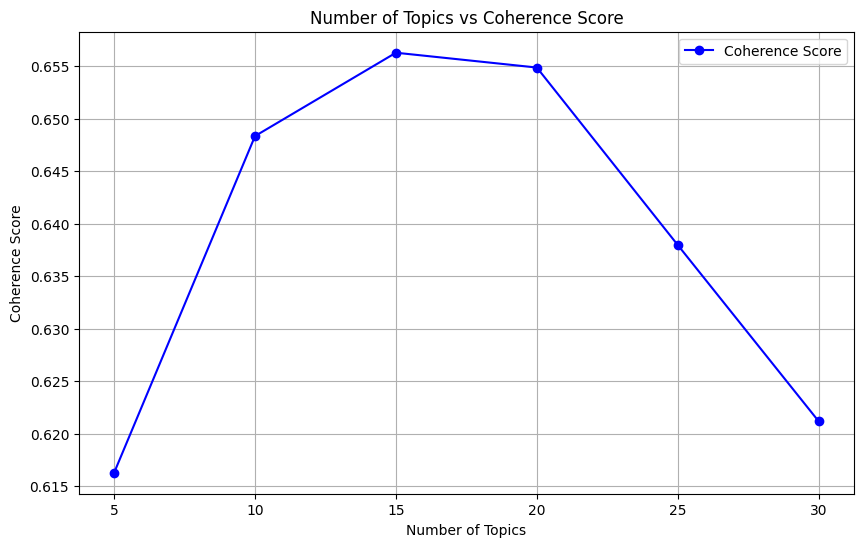

In [ ]:
# Specify the range of number of topics to search within
min_topics = 5
max_topics = 30
step_size = 5
topics_range = range(min_topics, max_topics+1, step_size)

# Perform Grid Search and compute coherence scores for different number of topics
coherence_scores = []
for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=dialogue['processed_text'], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

# Find the optimal number of topics with the highest coherence score
optimal_num_topics = topics_range[np.argmax(coherence_scores)]
print("Optimal Number of Topics:", optimal_num_topics)
print("Coherence Score for Optimal Number of Topics:", max(coherence_scores))

# Plotting the relationship between the number of topics and coherence score
plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker='o', color='b', label='Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Number of Topics vs Coherence Score')
plt.xticks(topics_range)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Number of topics for the LDA model
num_topics = 15

# Build the LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Print the topics
pprint(lda_model.print_topics())

[(0,
  '0.117*"thing" + 0.038*"speech" + 0.026*"accident" + 0.025*"fingers" + '
  '0.024*"boss" + 0.024*"father" + 0.023*"diaper" + 0.020*"movie" + '
  '0.017*"food" + 0.017*"weekend"'),
 (1,
  '0.074*"phone" + 0.052*"money" + 0.041*"lot" + 0.024*"mark" + 0.021*"office" '
  '+ 0.021*"month" + 0.018*"arrest" + 0.017*"question" + 0.015*"story" + '
  '0.015*"unit"'),
 (2,
  '0.062*"hell" + 0.056*"way" + 0.045*"part" + 0.042*"hours" + 0.038*"butt" + '
  '0.036*"evidence" + 0.035*"fire" + 0.023*"word" + 0.020*"fountain" + '
  '0.020*"eyes"'),
 (3,
  '0.133*"time" + 0.053*"guys" + 0.045*"one" + 0.044*"work" + 0.035*"today" + '
  '0.034*"eye" + 0.027*"duty" + 0.025*"thing" + 0.021*"chance" + '
  '0.020*"streets"'),
 (4,
  '0.061*"job" + 0.060*"chairs" + 0.053*"news" + 0.046*"case" + 0.038*"desk" + '
  '0.037*"plan" + 0.036*"things" + 0.020*"thing" + 0.016*"risk" + '
  '0.015*"plane"'),
 (5,
  '0.057*"hands" + 0.053*"door" + 0.030*"top" + 0.027*"idea" + 0.027*"love" + '
  '0.027*"energy" + 0.0

In [ ]:
# import the CoherenceModel class from the Gensim library
from gensim.models.coherencemodel import CoherenceModel

# compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, texts=dialogue['processed_text'], dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# print out result
print(f'Coherence Score: {coherence_score}')

Coherence Score: 0.6528995301576938


<ipython-input-64-6e84cfb83f24>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axs[i].barh(words, word_freq, alpha=0.75, color=plt.cm.get_cmap('tab20')(i))


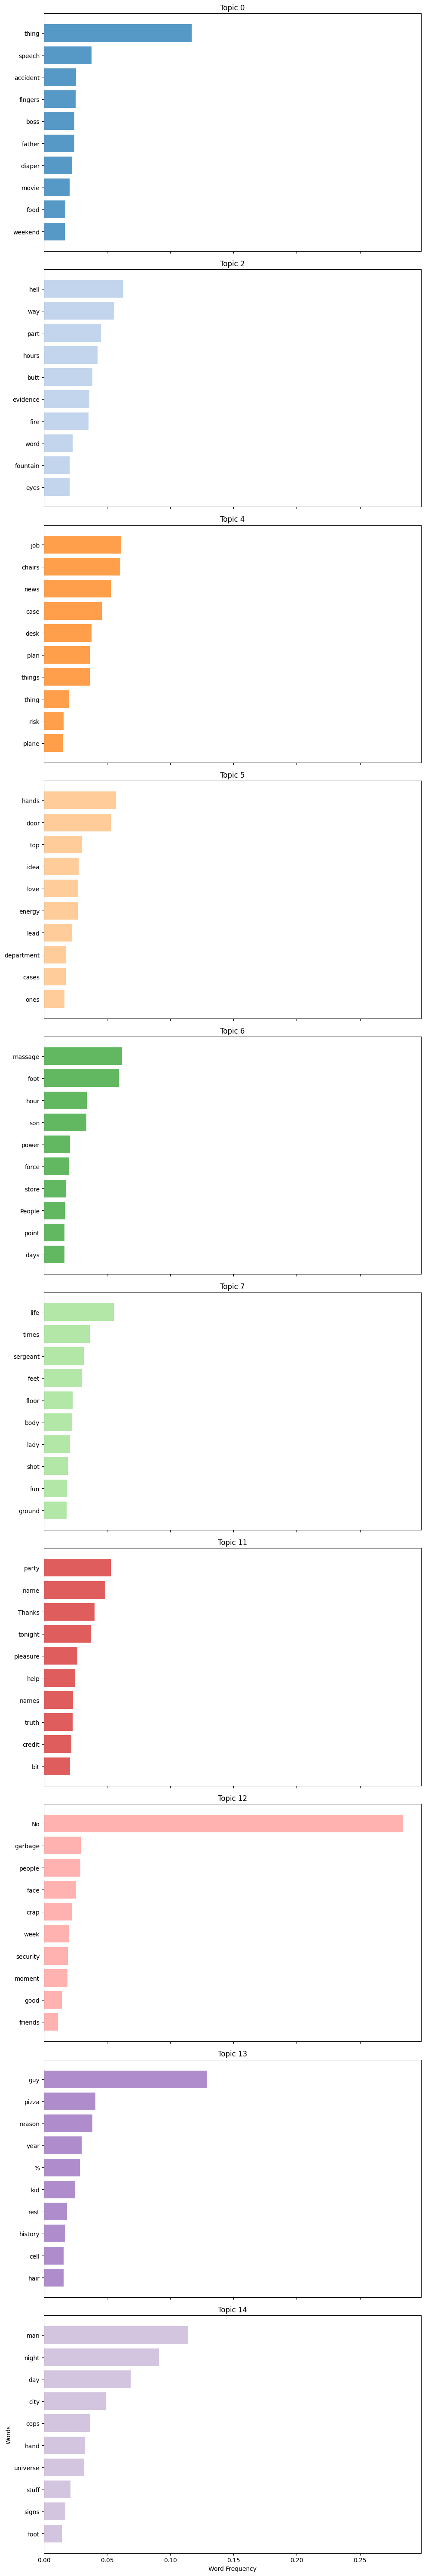

In [ ]:
topics_words_sorted = sorted(topics_words, key=lambda x: x[0])

# Plotting the bar graph for each topic
fig, axs = plt.subplots(len(topics_words_sorted), 1, figsize=(10, 6*len(topics_words_sorted)), sharex=True)

for i, (topic_num, topic_words) in enumerate(topics_words_sorted):
    words = [word for word, _ in topic_words]
    word_freq = [freq for _, freq in topic_words]
    axs[i].barh(words, word_freq, alpha=0.75, color=plt.cm.get_cmap('tab20')(i))
    axs[i].set_title(f'Topic {topic_num}')
    axs[i].invert_yaxis()  # Invert y-axis to display the most frequent words on top

plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()